## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 2: Text Classification and Neural Network
### Total Points: 100 points

In Assignment 2, you will be dealing with text classification using Multinomial Naive Bayes and Neural Networks. You will also be dealing with vector visualization. In the previous assingment you implemented Bag of Words as the feature selection method. However, in this assignment you will be using TF-IDF Vectorization instead of Bag of Words. We recommend starting with this assignment a little early as the datasets are quite large and several parts of the assignment might take long duration to execute. 

## Question 1 Text Classification

In the first question you will be dealing with 20 News Group Dataset. You are required to implement TF-IDF vectorization from scratch and perform Multinomial Naive Bayes Classification on the News Group Dataset.
You may use appropriate packages or modules for fitting the Multinomial Naive Bayes Model, however, the implementation of the TF-IDF Vectorization should be from the scratch.

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date.

Link to the original dataset: http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

You can also import the dataset from sklearn.datasets

In [ ]:
#importing the libraries
import string
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import pandas as pd
import re
import numpy as np
from nltk.tokenize import  word_tokenize 
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from scipy.sparse import csr_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [ ]:
# Import the 20 news group dataset utilizing sklearn library

mydata_train = fetch_20newsgroups(subset='train')

mydata_test = fetch_20newsgroups(subset='test')


In [ ]:
# Print the news groups(target) in the dataset

pprint(list(mydata_train.target_names))

In [ ]:
# What is the type of 'mydata_train' and 'mydata_test'

print(type(mydata_train))
print(type(mydata_test))

In [ ]:
# Check the length of the data

print(len(mydata_train.data))
print(len(mydata_train.filenames))
print(len(mydata_test.data))
print(len(mydata_test.filenames))

### Expected Output: 
11314

11314

7532

7532

## Extracting Features from the Dataset                        (20 Points)

In order to perform machine learning on text documents, we first need to turn the text content into numerical feature vectors.

### TF-IDF Vectorization

Our model cannot simply read the text data so we convert it into numerical format. In order to convert the data into numerical format we create vectors from text.

For this particular purpose we could either employ Bag of Words or TF-IDF Vectorization

Bag of Words just creates a set of vectors containing the count of word occurrences in the document (reviews), while the TF-IDF model contains information on the more important words and the less important ones as well.

TF-IDF stands for Term Frequency-Inverse Document Frequency, which instead of giving more weight to words that occur more frequently, it gives a higher weight to words that occur less frequently.

Ref:https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/#:~:text=Bag%20of%20Words%20just%20creates,less%20important%20ones%20as%20well.

TF-IDF = Term Frequency (TF) * Inverse Document Frequency (IDF)

Term Frequency is the measure of the frequency of words in a document. It is the ratio of the number of times the word appears in a document compared to the total number of words in that document.

The words that occur rarely in the corpus have a high IDF score. It is the log of the ratio of the number of documents to the number of documents containing the word.

idf(t) = log(N/(df + 1))

In [ ]:
text = mydata_train.data
test = mydata_test.data

In [ ]:
mydata_train.target_names

## Preprocessing the Corpus

In [ ]:
# Preprocessing the data
lines = [] 
word_list = [] 
 
for line in text:
    #tokenize the text documents and update the lists word_list and lines
    cleaned = line.translate(str.maketrans('', '', string.punctuation)).lower()
    lines.append(word_tokenize(cleaned))

# Make sure the word_list contains unique tokens
word_list = np.unique(np.concatenate(lines, axis=0))

# Calculate the total documents present in the corpus
total_docs = len(lines)
 
#Create a dictionary to keep track of index of each word
dict_idx = {word_list[i]: i for i in range(0, len(word_list))}

In [ ]:
# Create a frequency dictionary
 
def frequency_dict(lines):
    '''
    lines: list containing all the tokens
    ---
    freq_word: returns a dictionary which keeps the count of the number of documents containing the given word
    '''
    word_list = np.unique(np.concatenate(lines, axis=0))
    freq_word = {word_list[i]: 0 for i in range(0, len(word_list))}
    for word in word_list:
        for line in lines:
            if word in line:
                freq_word[word] += 1
    
    return freq_word

In [ ]:
# Create a dictionary containing the frequency of words utilizing the 'frequency_dict' function

# Expect this chunk to take a comparatively longer time to execute since our dataset is large

freq_word = frequency_dict(lines)

freq_word

In [ ]:
# Create a function to calculate the Term Frequency

def term_frequency(document, word):
    
    tf = document.count(word)/len(document)
    '''
    document: list containing the entire corpus
    word: word whose term frequency is to be calculated
    ---
    tf: returns term frequency value
    '''
    
    return tf

In [ ]:
# Create a function to calculate the Inverse Document Frequency
 
def inverse_df(word):
    
    idf = np.log((total_docs + 1)/(freq_word[word] + 1)) + 1
    
    '''
    word: word whose inverse document frequency is to be calculated
    --- 
    idf: return inverse document frequency value
    '''
    
    return idf

In [ ]:
#Create a function to combine the term frequencies (TF) and inverse document (IDF) frequencies calculated above to get TF-IDF

def tfidf(sentence):
    
    tf = {}
    idf = {}
    tf_idf_vec = {}
    word_list = []
    for review_ind, line in enumerate(sentence):
        for word in line:
            if len(word) < 2: #only considerng words with more than 1 letter
                continue
            tf[word, review_ind] = term_frequency(line, word)
            

    word_list = sorted(np.unique(np.concatenate(sentence, axis=0)))
    
    for word in word_list:
        idf[word] = inverse_df(word)
    
    for keys in tf.keys():
        tf_idf_vec[keys] = tf[keys] * idf[keys[0]]
        
    sm = csr_matrix((len(sentence), len(word_list))).toarray()
    
    dict_idx = {word_list[i]: i for i in range(0, len(word_list))}
    
    for row, line in enumerate(sentence):
        for word, ind in zip(dict_idx.keys(), dict_idx.values()):
            sm[row, ind] = tf_idf_vec.get((word, row), 0)
            
    '''
    sentence: list containing the entire corpus
    dict: dictionary keeping track of index of each word
    ---
    tf_idf_vec: returns computed tf-idf
    '''
        
    return sm

In [ ]:
#Compute the vectors utilizing the 'tfidf' function created above to obtain a TF-IDF Encoded text corpus

X = tfidf(lines)

In [ ]:
X = preprocessing.normalize(X, norm='l2')

## Multinomial Naive Bayes (10 Points)

In [ ]:
#Fit a Multinomial Naive Bayes Model on our dataset

model = MultinomialNB()
y_true = mydata_train.target
model.fit(X, y_true)


In [ ]:
#Perform testing on the train dataset

y_pred = model.predict(X)

In [27]:
#Calculate the F1 Score and the Accuracy

F1_score = f1_score(y_true, y_pred, average='macro')
Accuracy = accuracy_score(y_true, y_pred, normalize=True)
print("F1 Score: ", F1_score)
print("Accuracy: ", Accuracy)

F1 Score:  0.9149154840221071
Accuracy:  0.9305285487007248


### Expected Output:
F1 Score: 0.9533633964397735

Accuracy: 0.9524482941488421

Your accuracy does not have to be exactly the same. This is just to give you an estimate of what could you expect your accuracy to be around.

## Question 2 Vector Visualization

In this unsupervised learning task we are going to cluster wikipedia articles into groups using T-SNE visualization after vectorization.

### Collect articles from Wikipedia (10 points)

In this section we will download articles from wikipedia and then vectorize them in the next step. You can select somewhat related topics or fetch the articles randomly. 
(Use dir() and help() functions or refer wikipedia documentation)
You may also pick any other data source of your choice instead of wikipedia.

In [ ]:
# install libraries
!pip install wikipedia

In [ ]:
import wikipedia
from wikipedia.exceptions import WikipediaException

'''
 Generate a list of wikipedia article to cluster 
 You can maintain a static list of titles or generate them randomly using wikipedia library
 Some topics include:
 ["Northeastern Unversity", "Natural language processing", "Machine learning", "Quantum machine learning", "Artificial intelligence", "Data science", "Master in Data Science", 
 "Bank of America", "Visa Inc.", "European Central Bank", "Bank", "Financial technology","International Monetary Fund", 
 "Basketball", "Swimming", "Tennis", "Football", "College Football", "Association Football"]

 You can add more topics from different categories so that we have a diverse dataset to work with. 
 Ex- About 3+ categories(groups), 3+ topics in each category, 3+ articles in each topic
'''

# selected topics
topics = []

# list of articles to be downloaded
articles = ["Stanley Kubrick", "Akira Kurosawa", "Christopher Nolan", "Sailor", "Engineer", "Pilot", "Natural language processing", "Machine learning", "Quantum machine learning", "Artificial intelligence", "Data science", "Master in Data Science", 
 "Bank of America", "Visa Inc.", "European Central Bank", "Bank", "Financial technology","International Monetary Fund", 
 "Basketball", "Swimming", "Tennis", "Football", "College Football", "Association Football"]

# download and store articles (summaries) in this variable
data = []
for article in articles:
    data.append(wikipedia.page(article , auto_suggest=False).summary)


### Cleaning the Data (5 points)
In this step you will decide whether to clean the data or not. If you choose to clean, you may utilize the clean function from assignment 1.

**Question:** Why are you (not) choosing to clean the data? Think in terms of whether cleaning data will help in the clustering or not.

**I am choosing to clean the data in this step because cleaning removes all the punctuations and stop words which are redundant and provide no useful information about the data. Sometimes removing those redundant data provides better identification and allocation of data points into the clusters. Here, even if we dont clean, CountVectorizer performs a default cleaning of removing punctuations and stop words before vectorizing if specified in the parameters.**

**Answer(1-3 sentences):** 

In [29]:
# You can use Assignment 1's clean message function
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
from nltk.tokenize.treebank import TreebankWordDetokenizer
warnings.filterwarnings("ignore")
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('stopwords')

def clean_message(message):
    message_cleaned = re.sub(r'<br /><br />', '', message)
    message_cleaned = message_cleaned.translate(str.maketrans('', '', string.punctuation)).lower()
    message_tokens = word_tokenize(message_cleaned)
    tokens_without_sw = [word for word in message_tokens if not word in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    stem_sentence = [lemmatizer.lemmatize(x) for x in tokens_without_sw]
    message = " ".join(stem_sentence)
    return message



### Vectorize the articles (5 points)

In this step, we will vectorize the text data. You can use TfidfVectorizer() or countVectorizer() from sklearn library.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
data_clean = []
for summary in data:
    data_clean.append(clean_message(summary))
tfidfvec = CountVectorizer()
X = tfidfvec.fit_transform(data_clean)

In [31]:
print(X.shape)

(24, 1919)


### Sample Output:
(36, 1552)

### Plot Articles (10 points)
Now we will try to verify the groups of articles using T-SNE from sklearn library.

In [32]:
from sklearn.manifold import TSNE
t_sne = TSNE(2, verbose=1)

# call TSNE() to fit the data

z = t_sne.fit_transform(X) 
data = pd.DataFrame({'col_1' : z[:,0], 'col_2' : z[:,1]})

[t-SNE] Computing 23 nearest neighbors...
[t-SNE] Indexed 24 samples in 0.000s...
[t-SNE] Computed neighbors for 24 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.018208
[t-SNE] KL divergence after 1000 iterations: 0.461402


Plot and annotate the points with different markers for different expected groups.

<AxesSubplot:xlabel='col_1', ylabel='col_2'>

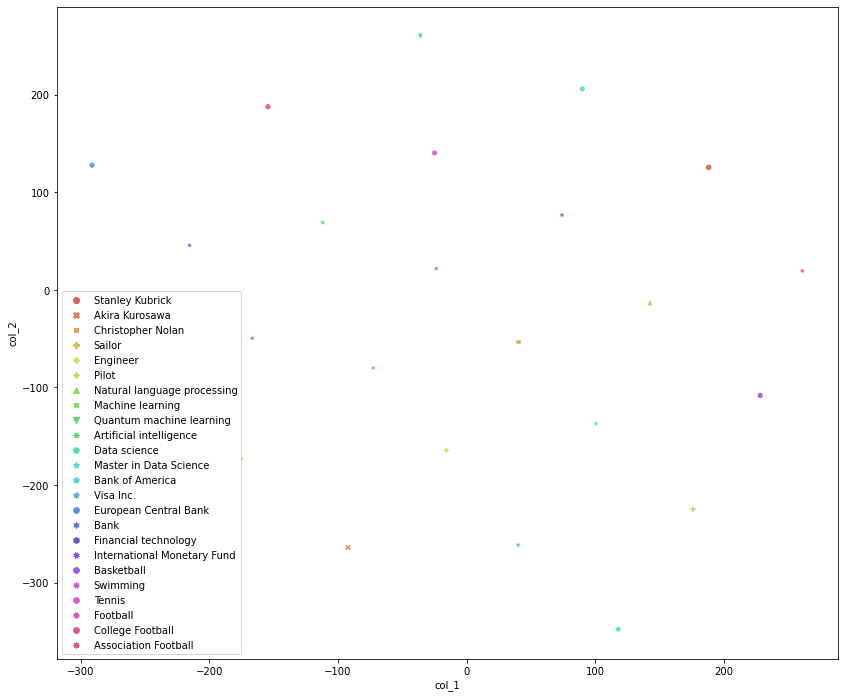

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,12))
sns.scatterplot(
    x = data['col_1'], y=data['col_2'],
    hue = articles,
    palette = sns.color_palette("hls", 24),
    legend = "full",
    alpha = 0.9,
    style = articles
)

**Question:** Comment about the categorizion done by T-SNE. Do the articles of related topics cluster together? (5 points)

**Answer(1-3 sentences):**  
**Yes, T-SNE first creates a conditional probability distribution that represents similarities between neighbours. 
Similarity of a point 'a' to 'b' is the conditional probability that 'a' would pick 'b' as its neighbour. In this context, the articles are grouped based on the similarities between them. So T-SNE is performing well here.**
  


# Question 3 Building Neural Networks

### We are gonna use Emotions Dataset for this task. We need to classify the given text into different kind of emotions like happy,sad,anger etc.., 

### We are providing train.txt and val.txt files along with this notebook. 

### Library Imports and Utility functions

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
#string.punctuation
import nltk
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

def clean_text(text):
  # From the last assignment
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

### Q) Importing the datasets and do the necessary cleaning and convert the text into the vectors which are mentioned in the below code blocks. (10 points)

In [45]:
 # Import the train.txt and val.txt file into pandas dataframe format 

# train 
df_train = pd.read_csv('train.txt' , delimiter = ';', header = None)
# validation
df_validation = pd.read_csv('val.txt', delimiter = ';', header = None)
# and printout the train.shape and validation.shape 
print("Train_shape : ", df_train.shape, "Validation_shape : ", df_validation.shape)
# expected shape of train dataset is (16000,2) and validation dataset is (2000,2)

Train_shape :  (16000, 2) Validation_shape :  (2000, 2)


In [47]:
# clean the text in the train and validation dataframes using the clean_text function provided above
df_train[0] = [clean_text(text) for text in df_train[0]]
df_validation[0] = [clean_text(text) for text in df_validation[0]]

In [49]:
# initialise count vectorizer from sklearn module with default parameter
from sklearn.feature_extraction.text import CountVectorizer
countvect = CountVectorizer()
# fit on train dataset and transform both train and validation dataset
df_countvect_train = countvect.fit_transform(df_train[0])
df_countvect_validation = countvect.transform(df_validation[0])


In [56]:
 # initialise tfidf vectorizer from sklearn module with default parameter
tfidfv = TfidfVectorizer()
# fit on train dataset and transform both train and validation dataset
df_tf_transform_train = tfidfv.fit_transform(df_train[0])
df_tf_transform_validation = tfidfv.transform(df_validation[0])

In [57]:
# initialise label encoder from sklearn module
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
# fit on train labels and transform both train and validation labels
df_train[1] = le.fit_transform(df_train[1])
df_validation[1] = le.fit_transform(df_validation[1])

In [61]:
# convert the labels into one hot encoding form

training_label = pd.get_dummies(df_train[1])

validation_label = pd.get_dummies(df_validation[1])

### Q) Build the neural networks using tensorflow keras by following the below instructions. Evaluate the model on different metrics and comment your observations. (15 points)

In [62]:
import tensorflow as tf

tf.random.set_seed(42)


# complete this linear model in tensorflow
def build_model(X):
    
    model = tf.keras.models.Sequential() 
    
    # layer 1 : input layer
    inp = tf.keras.Input((X.shape[1],))
    model.add(inp)
    
  # layer 2 : add the dense layer with 2048 units and relu activation
    model.add(tf.keras.layers.Dense(units = 2048 , activation = 'relu'))
    
  # layer 3 : add the dropout layer with dropout rate of 0.5
    model.add(tf.keras.layers.Dropout(rate = 0.5))
    
  # layer 4 : add the dense layer with 1024 units with tanh activation and with l2 regularization
    model.add(tf.keras.layers.Dense(units = 1024 , activation = 'tanh', kernel_regularizer='l2'))
    
  # layer 5 : add the dropout layer with dropout rate of 0.5
    model.add(tf.keras.layers.Dropout(rate = 0.5))
    
  # layer 6 : add the dense layer with 512 units with tanh activation and with l2 regularization
    model.add(tf.keras.layers.Dense(units = 512 , activation = 'tanh', kernel_regularizer='l2'))
    
  # layer 7 : add the dropout layer with dropout rate of 0.5
    model.add(tf.keras.layers.Dropout(rate = 0.5))
    
  # layer 8 : add the dense layer with 256 units with tanh activation and with l2 regularization
    model.add(tf.keras.layers.Dense(units = 256 , activation = 'tanh', kernel_regularizer='l2'))
    
  # layer 9 : add the dropout layer with dropout rate of 0.5
    model.add(tf.keras.layers.Dropout(rate = 0.5))
    
  # layer 10 : add the dense layer with 128 units with tanh activation and with l2 regularization
    model.add(tf.keras.layers.Dense(units = 128 , activation = 'tanh', kernel_regularizer='l2'))
    
  # layer 11 : add the dropout layer with dropout rate of 0.5
    model.add(tf.keras.layers.Dropout(rate = 0.5))
    
  # layer 12 : output layer with units equal to number of classes and activation as softmax
    model.add(tf.keras.layers.Dense(units = 6, activation = 'softmax'))
    
  # use loss as categorical crossentropy, optimizer as rmsprop and evaluate model on auc,precision,recall,accuracy 
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='rmsprop', metrics=['AUC', 'Precision', 'Recall', 'Accuracy'])
    
    return model


In [63]:
# call the build_model function and initialize the model

build = build_model(df_countvect_train)

build.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              27516928  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               1

In [ ]:
# train and validate the model on the count vectors of text which we have created initially for 10 epochs, 
# adjust batch size according to your computation power (suggestion use : 8)

model_1 = build.fit(
    x = df_countvect_train.toarray(), 
    y = training_label,
    epochs=10, 
    steps_per_epoch=2000,
    batch_size = 8,
    validation_data=(df_countvect_validation.toarray(), validation_label)
)



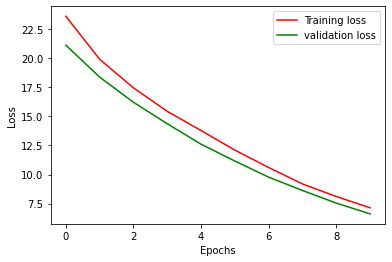

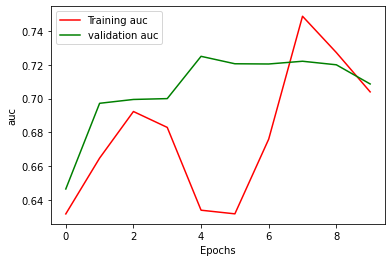

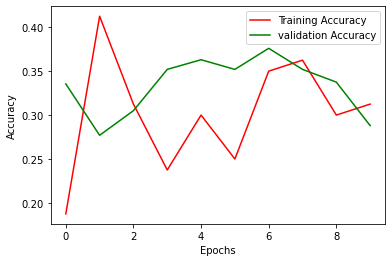

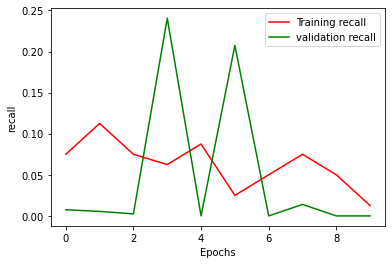

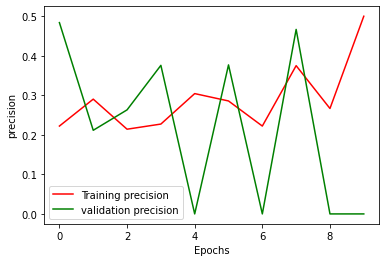

In [69]:
# plot train loss vs val loss, train auc vs val auc, train recall vs val recall, train precision vs val precision and train accuracy vs val accuracy and comment your observations
loss_train = model_1.history['loss']
loss_val = model_1.history['val_loss']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


loss_train = model_1.history['auc']
loss_val = model_1.history['val_auc']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training auc')
plt.plot(epochs, loss_val, 'g', label='validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()



loss_train = model_1.history['Accuracy']
loss_val = model_1.history['val_Accuracy']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training Accuracy')
plt.plot(epochs, loss_val, 'g', label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



loss_train = model_1.history['recall']
loss_val = model_1.history['val_recall']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training recall')
plt.plot(epochs, loss_val, 'g', label='validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()


loss_train = model_1.history['precision']
loss_val = model_1.history['val_precision']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training precision')
plt.plot(epochs, loss_val, 'g', label='validation precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

In [66]:
# again call the build_model function and initialize the model

build = build_model(df_tf_transform_train)

build.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 2048)              27516928  
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)              

In [78]:
# train and validate the model on the tfidf vectors of text which we have created initially for 10 epochs, 
# adjust batch size according to your computation power (suggestion use : 8)

model_2 = build.fit(
    x = df_tf_transform_train.toarray(), 
    y = training_label,
    epochs=10, 
    steps_per_epoch=2000,
    batch_size = 8,
    validation_data=(df_tf_transform_validation.toarray(), validation_label)
)

Epoch 1/10
2/2 [==============================] - 4s 4s/step - loss: 1.6736 - auc: 0.7945 - precision: 0.5000 - recall: 0.1875 - Accuracy: 0.3125 - val_loss: 1.8430 - val_auc: 0.7376 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_Accuracy: 0.3520
Epoch 2/10
2/2 [==============================] - 4s 3s/step - loss: 1.6194 - auc: 0.8301 - precision: 0.0000e+00 - recall: 0.0000e+00 - Accuracy: 0.4375 - val_loss: 1.8626 - val_auc: 0.7372 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_Accuracy: 0.3520
Epoch 3/10
2/2 [==============================] - 4s 3s/step - loss: 1.3848 - auc: 0.8863 - precision: 0.5000 - recall: 0.2500 - Accuracy: 0.5000 - val_loss: 1.9255 - val_auc: 0.7363 - val_precision: 0.5308 - val_recall: 0.0345 - val_Accuracy: 0.3520
Epoch 4/10
2/2 [==============================] - 4s 3s/step - loss: 1.8295 - auc: 0.7594 - precision: 0.6667 - recall: 0.1250 - Accuracy: 0.3750 - val_loss: 1.8660 - val_auc: 0.7376 - val_precision: 0.0000e+00 - val_recall

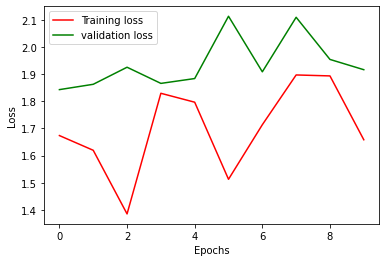

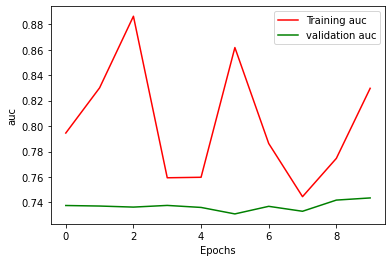

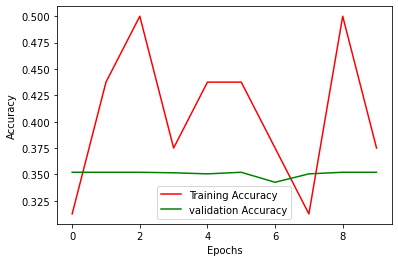

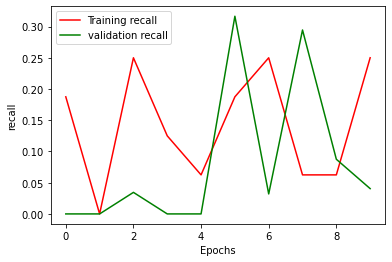

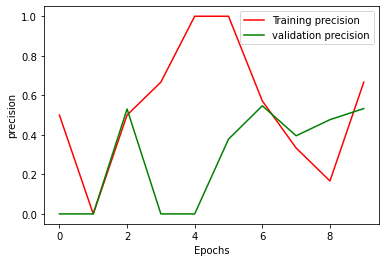

In [79]:
# plot train loss vs val loss, train auc vs val auc, train recall vs val recall, train precision vs val precision and train accuracy vs val accuracy and comment your observations

# plot train loss vs val loss, train auc vs val auc, train recall vs val recall, train precision vs val precision and train accuracy vs val accuracy and comment your observations
loss_train = model_2.history['loss']
loss_val = model_2.history['val_loss']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


loss_train = model_2.history['auc']
loss_val = model_2.history['val_auc']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training auc')
plt.plot(epochs, loss_val, 'g', label='validation auc')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.legend()
plt.show()



loss_train = model_2.history['Accuracy']
loss_val = model_2.history['val_Accuracy']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training Accuracy')
plt.plot(epochs, loss_val, 'g', label='validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



loss_train = model_2.history['recall']
loss_val = model_2.history['val_recall']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training recall')
plt.plot(epochs, loss_val, 'g', label='validation recall')
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.legend()
plt.show()


loss_train = model_2.history['precision']
loss_val = model_2.history['val_precision']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'r', label='Training precision')
plt.plot(epochs, loss_val, 'g', label='validation precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

## Question 4 Theory Question  

What is the difference between Count Vectorizer, TFIDF, Word2Vec and Glove? (5 points)

Count Vectorizer: It Converts a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix. CountVectorizer implements both tokenization and occurrence counting in a single class.

TF-IDF: This Converts a collection of raw documents to a matrix of TF-IDF features. TFIDF is 'Term Frequency Inverse Document Frequency' that represents how important a word is in a document. The value is large when a word occurs more frequently in a particular document or for words that are rare in the corpus. This produces a sparse matrix with few non-zer tfidf values in each row.

Word2Vec: The Word2Vec model is used to extract the notion of relatedness across words or products such as semantic relatedness, synonym detection, concept categorization, selectional preferences, and analogy. Unlike TF-IDF, order/placement of words in a document is given importance in Word2Vec.

GloVe: GloVe focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together. Glove is based on matrix factorization techniques on the word-context matrix. It first constructs a large matrix of (words x context) co-occurrence information, i.e. for each “word” (the rows), you count how frequently we see this word in some “context” (the columns) in a large corpus.  The number of “contexts” is of course large, since it is essentially combinatorial in size.

**Answer:**

What is the significant difference between the Niave Bayes Implementation using Bag of Words and TF-IDF? (5 points)

**Answer:**

Bag of Words just creates a set of vectors containing the count of word occurrences in the document (reviews), while the TF-IDF model contains information on the more important words and the less important ones as well. Bag of Words vectors are easy to interpret. However, TF-IDF usually performs better in machine learning models. While both Bag-of-Words and TF-IDF have been popular in their own regard, there still remained a void where understanding the context of words was concerned. Detecting the similarity between the words ‘spooky’ and ‘scary’, or translating our given documents into another language, requires a lot more information on the documents.